In [2]:
#python libraries
import os
import re
from datetime import datetime
import pytz
import copy

#other ML libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from prophet import Prophet
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
#ploting
import matplotlib.pyplot as plt
%matplotlib inline

/home/henrikhestnes/anaconda3/envs/LSTM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### DATA CLEANING

In [24]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", 
                     "Humidifier_humidity", "Humidifier_temperature","Temperature",
                     "Hum_temperature", "Hum_humidity"]
discrete_measurement_types = ["Door", "Water"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True)#.dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)
            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)
            # print(f"key: {measurement_frame.columns[0]} Value: {coloumn_name}")
            if measurement_type in discrete_measurement_types:
                #For Water Detection:
                #NOT_PRESENT == No water detected = 0
                #PRESENT     == water detected    = 1

                #For Door Sensors: - this is because sensor changes state based on if it detects objects in front of it
                #NOT_PRESENT == DOOR IS OPEN     = 0
                #PRESENT     == DOOR IS CLOSED   = 1
                
                measurement_frame.replace(['NOT_PRESENT', 'PRESENT'],[0, 1], inplace=True)
                measurement_frame = measurement_frame.resample('15T').ffill()
            else: #Contious measurement
                measurement_frame  = measurement_frame.resample('15T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..

    
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()

### FEATURE ENGINEERING ###

In [32]:
data = sensor_data.copy()
cols_to_drop = ['1MainBR_hum_temperature', '2BalconyEntrance_temperature', '2LRWindow_temperature',
                '2LivingRoomCenter_humidity_temperature', '2LivingRoom_humidifier_temperature', 
                '2Fireplace_temperature', '2Cooking_temperature', '2Stair_temperature'] #due to correlation
data = data.drop(cols_to_drop, axis=1)

data["0BTLivingRoom_temperature"] = (data["0BTCeiling_temperature"] + data["0BTFloor_temperature"])/2
data = data.drop("0BTFloor_temperature", axis=1).drop("0BTCeiling_temperature", axis=1).sort_index(axis=1)

data["1Entrance_temperature"] = (data["1Entrance1_temperature"] + data["1StairBottom_temperature"])/2
data = data.drop("1Entrance1_temperature", axis=1).drop("1StairBottom_temperature", axis=1).sort_index(axis=1)

door_cols = ['0BGuest_door', '0B_door', '1Main_door', '2FirePlace_door', '2Office_door']
data = data.drop(door_cols, axis=1)

drop_hum_and_water_data = True
if drop_hum_and_water_data:
    data = data.drop(data.columns[data.columns.str.endswith('humidity')], axis=1)
    data = data.drop(data.columns[data.columns.str.endswith('water')], axis=1)

data.index = data.index.tz_convert(None)

In [44]:
train_df_1 = data.loc[(data.index.month < 7) & (data.index.year == 2022)].copy()
train_df_2 = data.loc[((data.index.month > 8) & (data.index.year == 2022))|(data.index.year == 2023)].copy()
train_df = pd.concat([train_df_1, train_df_2])
val_df = data.loc[(data.index.month == 8) & (data.index.year == 2022)].copy()
test_df = data.loc[(data.index.month == 7) & (data.index.year == 2022)].copy()

train_labels = train_df.loc[:, data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_scaler.fit(train_df)
y_scaler.fit(train_labels)

train_df_scaled = x_scaler.transform(train_df)
train_df_scaled = pd.DataFrame(train_df_scaled, columns=train_df.columns)
test_df_scaled = x_scaler.transform(test_df)
test_df_scaled = pd.DataFrame(test_df_scaled, columns=test_df.columns)

print(f"Shape of train_df = {train_df.shape}, Shape of val_df = {val_df.shape}, Shape of test_df = {test_df.shape}")
print(f"Shape of labels = {train_labels.shape}")

Shape of train_df = (33214, 8), Shape of val_df = (2976, 8), Shape of test_df = (2976, 8)
Shape of labels = (33214, 7)


In [5]:
data.columns

Index(['0BRoom_temperature', '0BTLivingRoom_temperature',
       '1Entrance_temperature', '1GuestRoom_temperature',
       '1MainRoom_temperature', '1OutdoorEntrance_temperature',
       '2LivingRoomCenter_temperature', '2OfficeDesk_temperature'],
      dtype='object')

### 0BRoom_temperature

In [45]:
GFBedRoom = pd.DataFrame(train_df["0BRoom_temperature"].reset_index())
GFBedRoom = GFBedRoom.rename(columns={"timestamp": "ds", "0BRoom_temperature": "y"})
GFBedRoom.head(2)

,ds,y
0,2022-01-07 19:45:00,16.2
1,2022-01-07 20:00:00,16.2


In [46]:
model = Prophet()
model.fit(GFBedRoom)

19:40:16 - cmdstanpy - INFO - Chain [1] start processing
19:40:40 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
GFBedTest = pd.DataFrame(test_df["0BRoom_temperature"].reset_index()).rename(columns={"timestamp": "ds", "0BRoom_temperature": "y"})
GFBedTestDs = GFBedTest.drop("y", axis=1)
GFBedTestDs

,ds
0,2022-07-01 00:00:00
1,2022-07-01 00:15:00
2,2022-07-01 00:30:00
3,2022-07-01 00:45:00
4,2022-07-01 01:00:00
...,...
2971,2022-07-31 22:45:00
2972,2022-07-31 23:00:00
2973,2022-07-31 23:15:00
2974,2022-07-31 23:30:00


In [57]:
forecast = model.predict(GFBedTestDs)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-07-01 00:00:00,24.133067,22.360731,26.354028,24.133067,24.133067,0.139386,0.139386,0.139386,0.131105,0.131105,0.131105,0.008281,0.008281,0.008281,0.0,0.0,0.0,24.272454
1,2022-07-01 00:15:00,24.132267,22.328070,26.401190,24.132267,24.132267,0.118389,0.118389,0.118389,0.111357,0.111357,0.111357,0.007033,0.007033,0.007033,0.0,0.0,0.0,24.250657
2,2022-07-01 00:30:00,24.131467,22.236737,26.123878,24.131467,24.131467,0.095266,0.095266,0.095266,0.089471,0.089471,0.089471,0.005795,0.005795,0.005795,0.0,0.0,0.0,24.226734
3,2022-07-01 00:45:00,24.130667,22.188869,26.128457,24.130667,24.130667,0.070328,0.070328,0.070328,0.065760,0.065760,0.065760,0.004568,0.004568,0.004568,0.0,0.0,0.0,24.200996
4,2022-07-01 01:00:00,24.129867,22.198849,26.043625,24.129867,24.129867,0.043926,0.043926,0.043926,0.040574,0.040574,0.040574,0.003352,0.003352,0.003352,0.0,0.0,0.0,24.173793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,2022-07-31 22:45:00,21.756268,19.779752,23.757903,21.756268,21.756268,0.133868,0.133868,0.133868,0.190534,0.190534,0.190534,-0.056667,-0.056667,-0.056667,0.0,0.0,0.0,21.890136
2972,2022-07-31 23:00:00,21.755468,19.908576,23.881602,21.755468,21.755468,0.132026,0.132026,0.132026,0.184288,0.184288,0.184288,-0.052262,-0.052262,-0.052262,0.0,0.0,0.0,21.887494
2973,2022-07-31 23:15:00,21.754668,19.828803,23.774088,21.754668,21.754668,0.127307,0.127307,0.127307,0.175163,0.175163,0.175163,-0.047857,-0.047857,-0.047857,0.0,0.0,0.0,21.881975
2974,2022-07-31 23:30:00,21.753868,19.624534,23.829256,21.753868,21.753868,0.119735,0.119735,0.119735,0.163188,0.163188,0.163188,-0.043453,-0.043453,-0.043453,0.0,0.0,0.0,21.873604


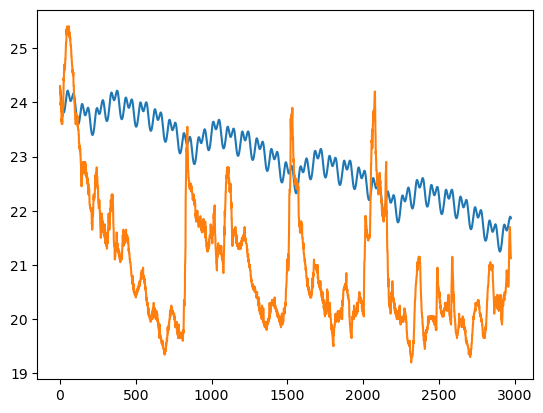

In [59]:
plt.plot(forecast["yhat"])
plt.plot(GFBedTest["y"])